# MPI calibration of a Grid5000 cluster

## Data exploration

In [1]:
import os
from extract_archive import *

archive_name = 'nancy_2018-08-03_1645238.zip'
result = extract_zip(archive_name)

In [2]:
!unzip -p $archive_name info.yaml

command: mpi_calibration.py run tocornebize --cluster grvingt --walltime 00:30:00
  --nbnodes 2 --expfile /tmp/foo.csv
deployment: false
grvingt-12.nancy.grid5000.fr:
  arp:
    api-proxy.nancy.grid5000.fr:
    - (172.16.79.118) at 00:16:3e:91:f3:fe [ether] on br0
    apt-global.nancy.grid5000.fr:
    - (172.16.79.109) at 52:54:00:90:2d:67 [ether] on br0
    dns.nancy.grid5000.fr:
    - (172.16.79.106) at 00:16:3e:30:fe:c0 [ether] on br0
    fnancy.nancy.grid5000.fr:
    - (172.16.79.101) at 00:16:3e:6a:bb:1b [ether] on br0
    graphene-49.nancy.grid5000.fr:
    - (172.16.64.49) at 00:e0:81:d5:08:5c [ether] on br0
    graphene-68.nancy.grid5000.fr:
    - (172.16.64.68) at 00:e0:81:d5:06:50 [ether] on br0
    graphique-1.nancy.grid5000.fr:
    - (172.16.67.1) at b0:83:fe:e5:c0:54 [ether] on br0
    grimani-1.nancy.grid5000.fr:
    - (172.16.73.1) at 24:6e:96:16:65:60 [ether] on br0
    grimoire-5.nancy.grid5000.fr:
    - (172.16.71.5) at 24:6e:96:02:96:90 [ether] on br0
    grisou-45.na

In [3]:
import pytree
print(pytree.__version__)
print(pytree.__git_version__)

0.0.6
0a153e9e34536887a3b697d1e0df121e8d6b9eeb


In [4]:
result['exp/exp_Recv.csv'].head()

,op,msg_size,start,duration,experiment,type,deployment,index
0,MPI_Recv,363688,0.000865,0.000050,nancy,exp/exp_Recv.csv,False,0
1,MPI_Recv,363688,0.001428,0.000044,nancy,exp/exp_Recv.csv,False,1
2,MPI_Recv,363688,0.001972,0.000043,nancy,exp/exp_Recv.csv,False,2
3,MPI_Recv,363688,0.002516,0.000043,nancy,exp/exp_Recv.csv,False,3
4,MPI_Recv,363688,0.003062,0.000042,nancy,exp/exp_Recv.csv,False,4


In [5]:
import pandas

# Special processing for the Pingpong dataset
df_pingpong = result['exp/exp_PingPong.csv']
pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                   msg_size = pingpong_send.msg_size,
                   start    = pingpong_send.start,
                   duration = pingpong_recv.duration + pingpong_send.duration
              ))

df_send = pingpong_send
df_isend = result['exp/exp_Isend.csv']
df_recv = result['exp/exp_Recv.csv']
df_wtime = result['exp/exp_Wtime.csv']
df_test = result['exp/exp_Test.csv']
df_iprobe = result['exp/exp_Iprobe.csv']

### MPI_Send

In [6]:
import pytree
import matplotlib.pyplot as plt

tmp = aggregate_dataframe(df_send)
reg_send = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_send.breakpoints)
reg_send

[7979, 32883, 63430, 151965]


-inf < x ≤ 7.979e+03
	y ~ 8.474e-11x + 2.358e-07
7.979e+03 < x ≤ 3.288e+04
	y ~ 9.949e-11x + 4.202e-06
3.288e+04 < x ≤ 6.343e+04
	y ~ 1.307e-10x + 7.213e-06
6.343e+04 < x ≤ 1.520e+05
	y ~ 1.171e-10x + 1.122e-05
1.520e+05 < x ≤ inf
	y ~ 8.112e-11x + 1.444e-05

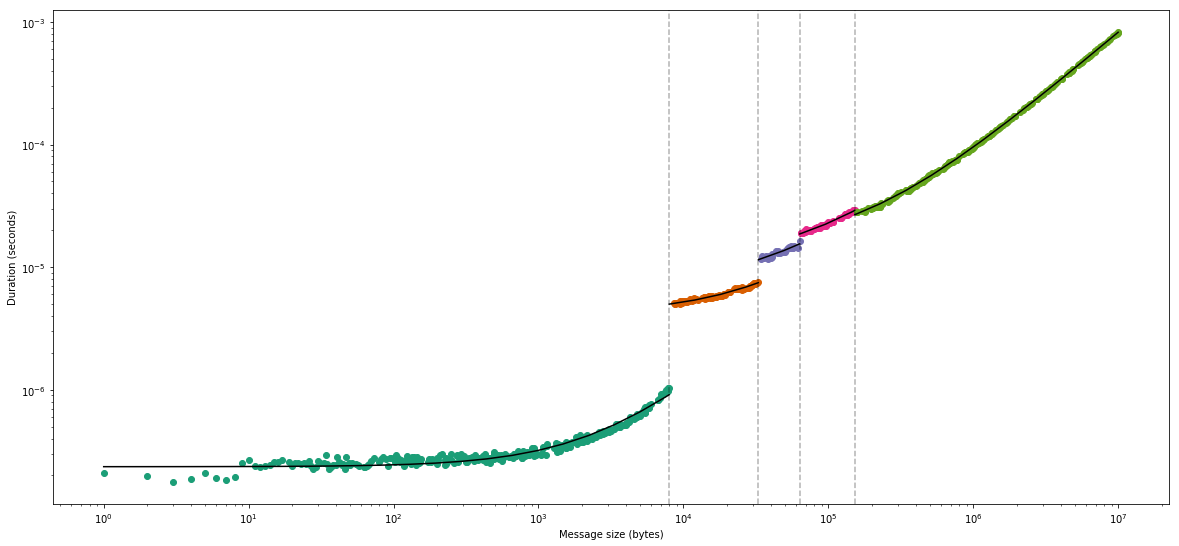

In [7]:
def draw_plot(reg, alpha=1):
    reg.plot_dataset(log=True, alpha=alpha)
    plt.xlabel('Message size (bytes)')
    plt.ylabel('Duration (seconds)')

draw_plot(reg_send)

### MPI_Isend

In [8]:
tmp = aggregate_dataframe(df_isend)
reg_isend = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_isend.breakpoints)
reg_isend

[10217, 15984, 63430]


-inf < x ≤ 1.022e+04
	y ~ 6.375e-11x + 5.711e-07
1.022e+04 < x ≤ 1.598e+04
	y ~ 3.895e-11x + 1.311e-06
1.598e+04 < x ≤ 6.343e+04
	y ~ 2.671e-11x + 2.588e-06
6.343e+04 < x ≤ inf
	y ~ 8.696e-15x + 5.882e-07

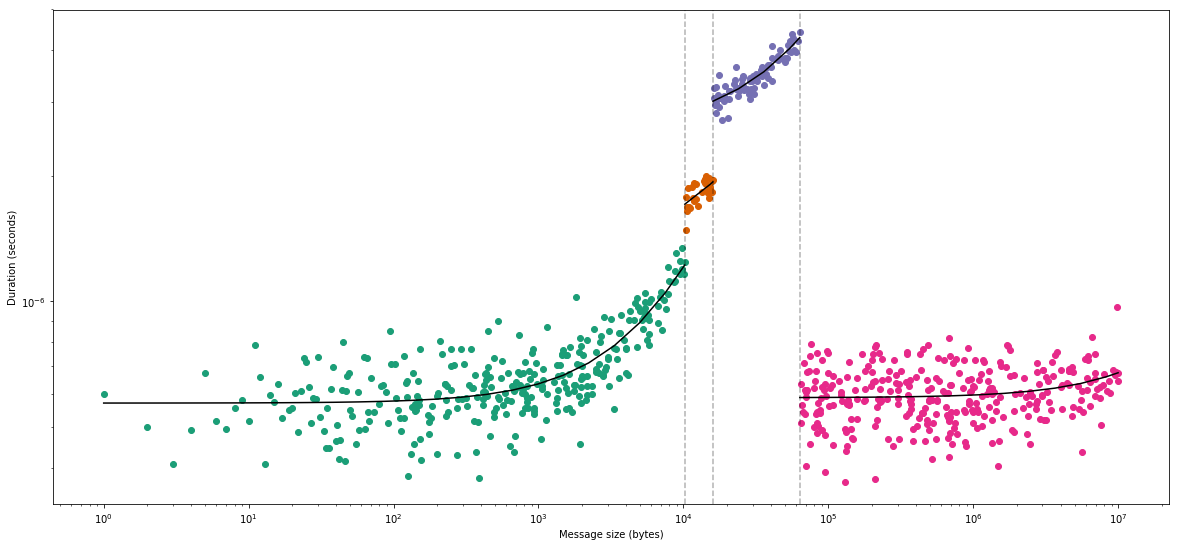

In [9]:
draw_plot(reg_isend)

### MPI_Recv

In [10]:
tmp = aggregate_dataframe(df_recv)
reg_recv = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_recv.breakpoints)
reg_recv

[32883, 63430, 403384]


-inf < x ≤ 3.288e+04
	y ~ 6.456e-11x + 1.139e-06
3.288e+04 < x ≤ 6.343e+04
	y ~ 8.081e-11x + 9.797e-07
6.343e+04 < x ≤ 4.034e+05
	y ~ 8.093e-11x + 1.082e-05
4.034e+05 < x ≤ inf
	y ~ 8.078e-11x + 1.052e-05

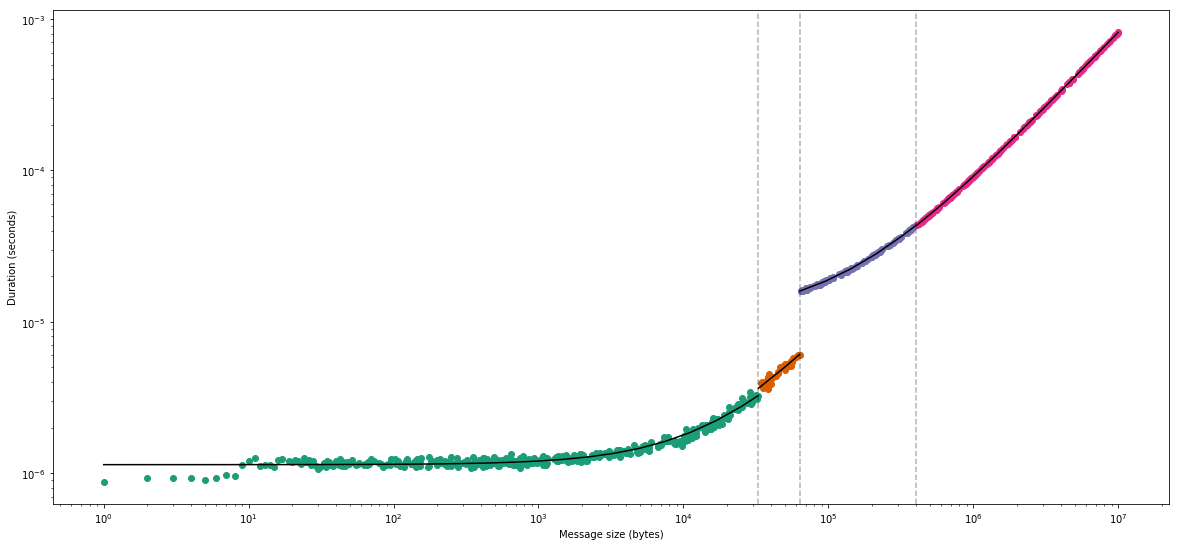

In [11]:
draw_plot(reg_recv)

### Pingpong

In [12]:
tmp = aggregate_dataframe(df_pingpong)
reg_pingpong = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_pingpong.breakpoints)
reg_pingpong

[12671, 32883, 63430, 151965]


-inf < x ≤ 1.267e+04
	y ~ 4.903e-10x + 3.323e-06
1.267e+04 < x ≤ 3.288e+04
	y ~ 1.985e-10x + 6.484e-06
3.288e+04 < x ≤ 6.343e+04
	y ~ 2.218e-10x + 1.213e-05
6.343e+04 < x ≤ 1.520e+05
	y ~ 1.993e-10x + 2.127e-05
1.520e+05 < x ≤ inf
	y ~ 1.619e-10x + 2.486e-05

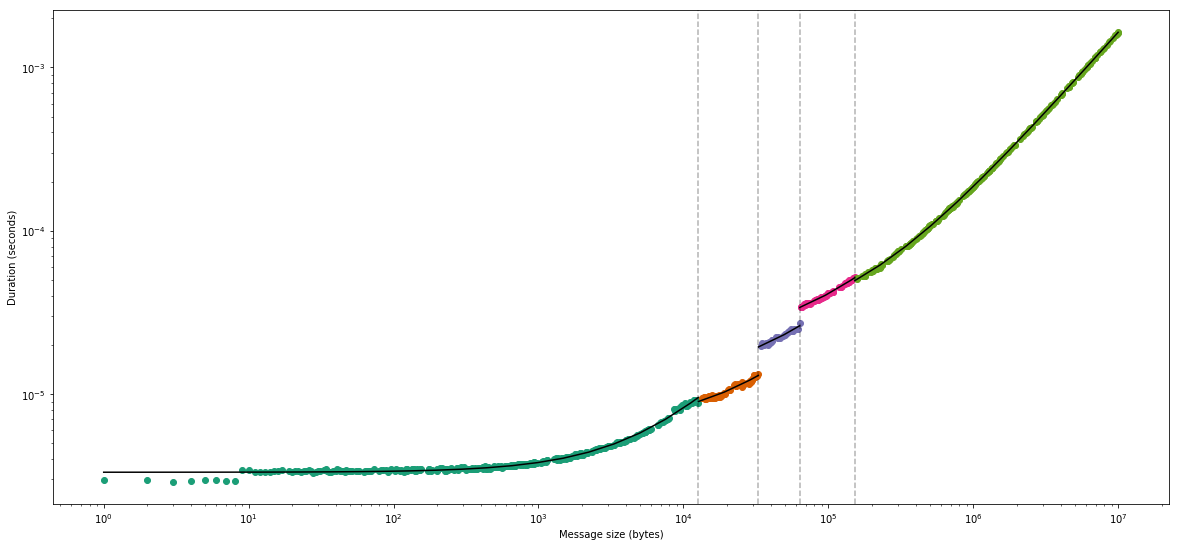

In [13]:
draw_plot(reg_pingpong)

## Better regressions

Let's use the same breakpoints everywhere and stop “cleaning” the datasets.

In [14]:
breakpoints = list(sorted(set(reg_send.breakpoints + reg_isend.breakpoints + reg_recv.breakpoints + reg_pingpong.breakpoints)))
print(breakpoints)

[7979, 10217, 12671, 15984, 32883, 63430, 151965, 403384]


### MPI_Send

-inf < x ≤ 7.979e+03
	y ~ 8.474e-11x + 2.358e-07
7.979e+03 < x ≤ 1.022e+04
	y ~ 1.831e-10x + 3.433e-06
1.022e+04 < x ≤ 1.267e+04
	y ~ 1.229e-10x + 3.976e-06
1.267e+04 < x ≤ 1.598e+04
	y ~ 6.589e-11x + 4.719e-06
1.598e+04 < x ≤ 3.288e+04
	y ~ 1.087e-10x + 3.960e-06
3.288e+04 < x ≤ 6.343e+04
	y ~ 1.307e-10x + 7.213e-06
6.343e+04 < x ≤ 1.520e+05
	y ~ 1.171e-10x + 1.122e-05
1.520e+05 < x ≤ 4.034e+05
	y ~ 7.874e-11x + 1.473e-05
4.034e+05 < x ≤ inf
	y ~ 8.108e-11x + 1.464e-05


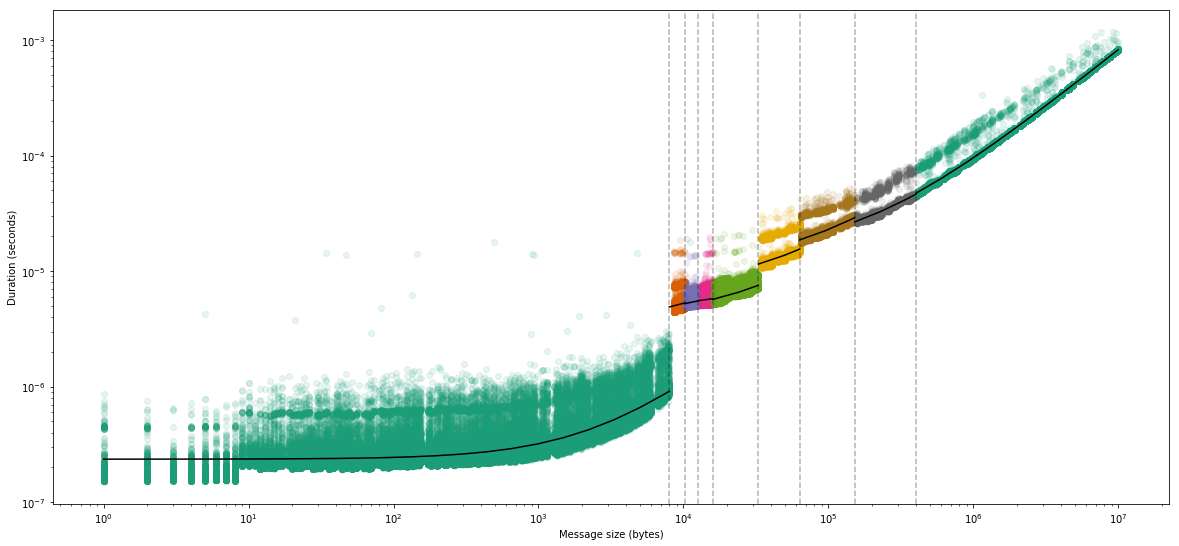

In [15]:
reg_send = pytree.compute_regression(x=df_send.msg_size, y=df_send.duration, breakpoints=breakpoints)
print(reg_send)
draw_plot(reg_send, alpha=0.1)

### MPI_Isend

-inf < x ≤ 7.979e+03
	y ~ 6.083e-11x + 5.739e-07
7.979e+03 < x ≤ 1.022e+04
	y ~ 4.670e-11x + 7.700e-07
1.022e+04 < x ≤ 1.267e+04
	y ~ 6.508e-11x + 1.010e-06
1.267e+04 < x ≤ 1.598e+04
	y ~ -1.221e-11x + 2.072e-06
1.598e+04 < x ≤ 3.288e+04
	y ~ 2.122e-11x + 2.715e-06
3.288e+04 < x ≤ 6.343e+04
	y ~ 2.756e-11x + 2.555e-06
6.343e+04 < x ≤ 1.520e+05
	y ~ -8.032e-13x + 6.599e-07
1.520e+05 < x ≤ 4.034e+05
	y ~ -2.099e-13x + 6.716e-07
4.034e+05 < x ≤ inf
	y ~ 1.037e-14x + 5.795e-07


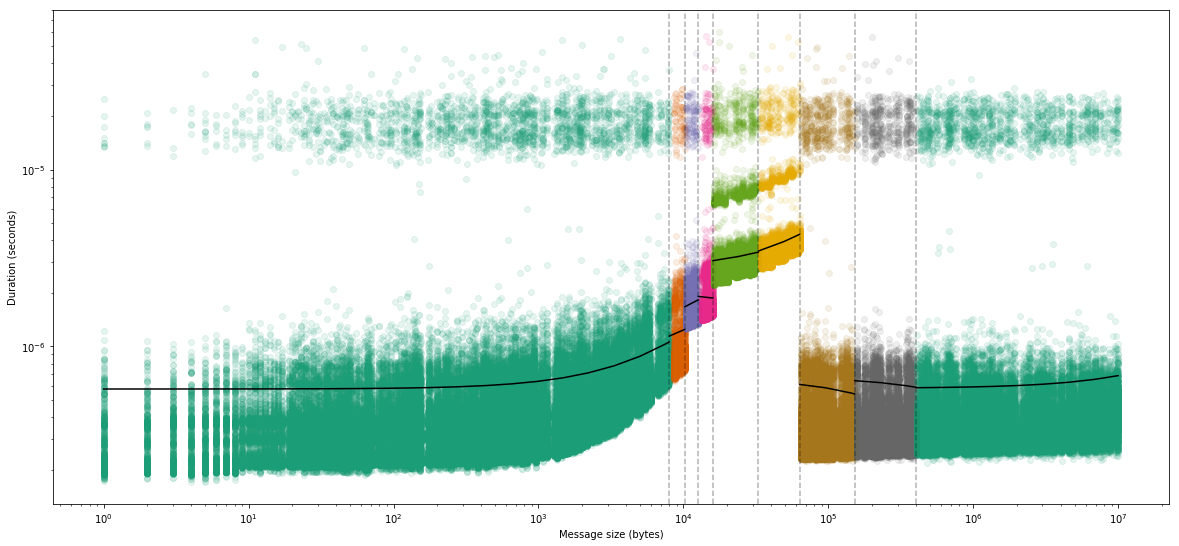

In [16]:
reg_isend = pytree.compute_regression(x=df_isend.msg_size, y=df_isend.duration, breakpoints=breakpoints)
print(reg_isend)
draw_plot(reg_isend, alpha=0.1)

### MPI_Recv

-inf < x ≤ 7.979e+03
	y ~ 6.181e-11x + 1.149e-06
7.979e+03 < x ≤ 1.022e+04
	y ~ 5.280e-11x + 1.118e-06
1.022e+04 < x ≤ 1.267e+04
	y ~ 5.608e-11x + 1.189e-06
1.267e+04 < x ≤ 1.598e+04
	y ~ 7.776e-11x + 8.984e-07
1.598e+04 < x ≤ 3.288e+04
	y ~ 7.062e-11x + 1.014e-06
3.288e+04 < x ≤ 6.343e+04
	y ~ 8.081e-11x + 9.797e-07
6.343e+04 < x ≤ 1.520e+05
	y ~ 8.135e-11x + 1.077e-05
1.520e+05 < x ≤ 4.034e+05
	y ~ 8.052e-11x + 1.094e-05
4.034e+05 < x ≤ inf
	y ~ 8.078e-11x + 1.052e-05


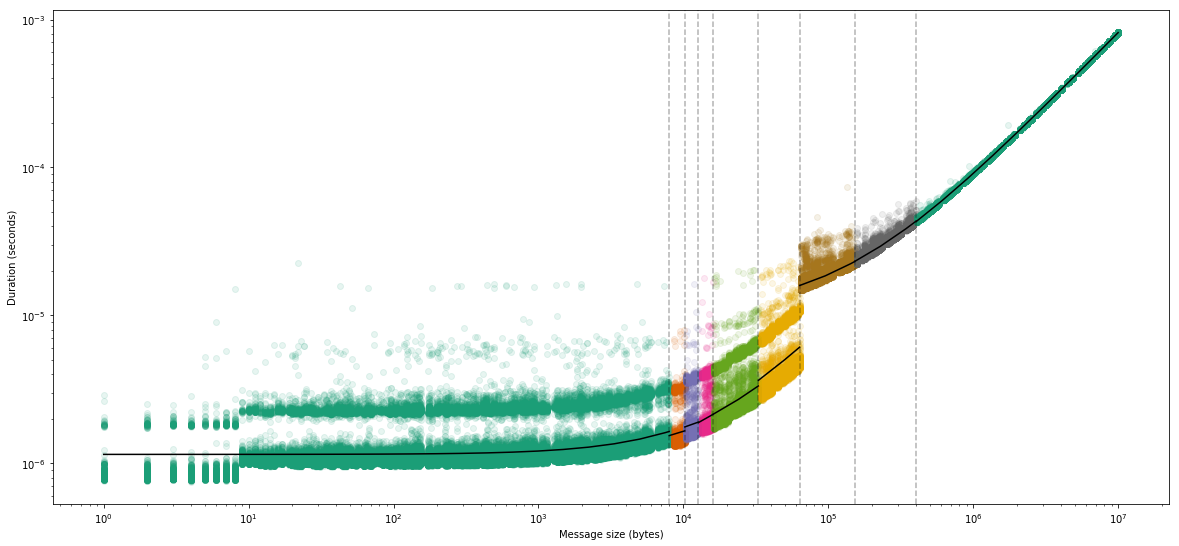

In [17]:
reg_recv = pytree.compute_regression(x=df_recv.msg_size, y=df_recv.duration, breakpoints=breakpoints)
print(reg_recv)
draw_plot(reg_recv, alpha=0.1)

### Pingpong

-inf < x ≤ 7.979e+03
	y ~ 4.731e-10x + 3.339e-06
7.979e+03 < x ≤ 1.022e+04
	y ~ 4.639e-10x + 3.943e-06
1.022e+04 < x ≤ 1.267e+04
	y ~ 2.899e-10x + 5.535e-06
1.267e+04 < x ≤ 1.598e+04
	y ~ 1.092e-10x + 7.927e-06
1.598e+04 < x ≤ 3.288e+04
	y ~ 2.123e-10x + 6.114e-06
3.288e+04 < x ≤ 6.343e+04
	y ~ 2.218e-10x + 1.213e-05
6.343e+04 < x ≤ 1.520e+05
	y ~ 1.993e-10x + 2.127e-05
1.520e+05 < x ≤ 4.034e+05
	y ~ 1.602e-10x + 2.486e-05
4.034e+05 < x ≤ inf
	y ~ 1.618e-10x + 2.512e-05


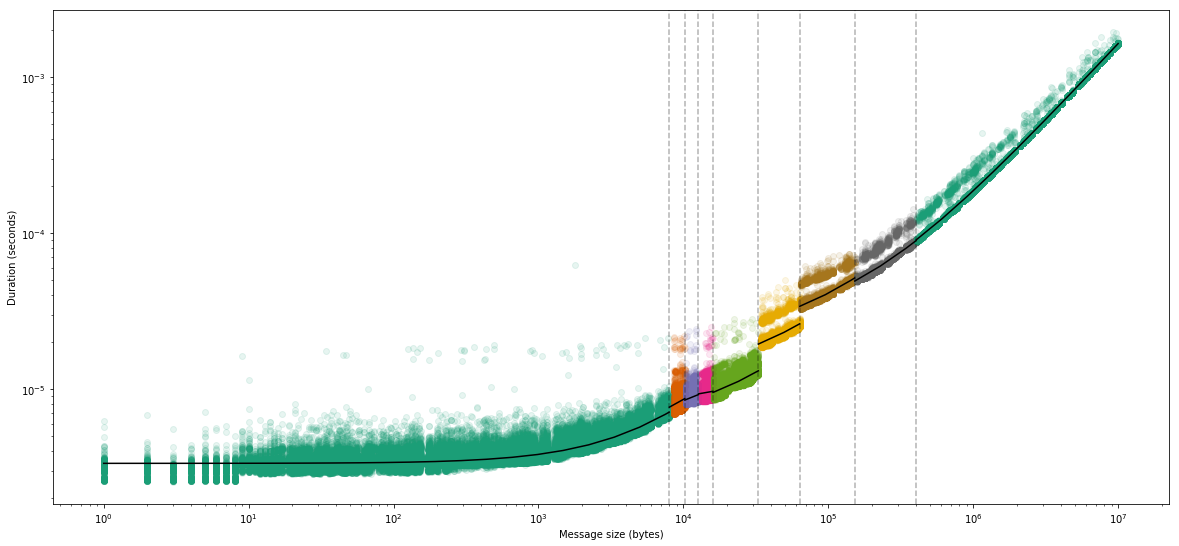

In [18]:
reg_pingpong = pytree.compute_regression(x=df_pingpong.msg_size, y=df_pingpong.duration, breakpoints=breakpoints)
print(reg_pingpong)
draw_plot(reg_pingpong, alpha=0.1)

In [19]:
df_reg_pingpong = reg_pingpong.to_pandas()
df_reg_recv = reg_recv.to_pandas()
df_reg_recv

,MSE,RSS,coefficient,intercept,max_x,min_x
0,2.178392e-13,3.387399e-08,6.181023e-11,1.148993e-06,7.979000e+03,-inf
1,3.202247e-13,1.601123e-09,5.280268e-11,1.118254e-06,1.021700e+04,7.979000e+03
2,4.141501e-13,3.106126e-09,5.608076e-11,1.188664e-06,1.267100e+04,1.021700e+04
3,6.104499e-13,4.883600e-09,7.776417e-11,8.983961e-07,1.598400e+04,1.267100e+04
4,1.154529e-12,2.886322e-08,7.061998e-11,1.013529e-06,3.288300e+04,1.598400e+04
5,4.354793e-12,7.620888e-08,8.080851e-11,9.796655e-07,6.343000e+04,3.288300e+04
6,2.324824e-12,7.904403e-08,8.135275e-11,1.076909e-05,1.519650e+05,6.343000e+04
7,1.547217e-12,4.564289e-08,8.052165e-11,1.093873e-05,4.033840e+05,1.519650e+05
8,3.983055e-13,3.883478e-08,8.078013e-11,1.051868e-05,inf,4.033840e+05


In [20]:
df_reg_transfer = pandas.DataFrame({'min_x': df_reg_pingpong.min_x,
                                    'max_x': df_reg_pingpong.max_x,
                                    'intercept': (df_reg_pingpong.intercept - df_reg_recv.intercept)/2,
                                    'coefficient': (df_reg_pingpong.coefficient - df_reg_recv.coefficient)/2,
                                   })
pandas.set_option('display.float_format', lambda x: '%.2e' % x)
df_reg_transfer

,min_x,max_x,intercept,coefficient
0,-inf,7.98e+03,1.09e-06,2.06e-10
1,7.98e+03,1.02e+04,1.41e-06,2.06e-10
2,1.02e+04,1.27e+04,2.17e-06,1.17e-10
3,1.27e+04,1.60e+04,3.51e-06,1.57e-11
4,1.60e+04,3.29e+04,2.55e-06,7.09e-11
5,3.29e+04,6.34e+04,5.58e-06,7.05e-11
6,6.34e+04,1.52e+05,5.25e-06,5.90e-11
7,1.52e+05,4.03e+05,6.96e-06,3.99e-11
8,4.03e+05,inf,7.30e-06,4.05e-11
